In [35]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [36]:
import numpy as np
import pandas as pd

In [37]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [312]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 
                         'train_accuracy', 'val_accuracy']] = cv_results[['param_C', 'mean_fit_time', 
                                                                          'mean_train_accuracy', 'mean_test_accuracy']]
    
    if 'mean_train_n_iter' in cv_results.columns:
        
        filtered_cv_results['n_iter'] = cv_results['mean_train_n_iter'].round().astype(int) + 1
    
    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Hinge loss

### Primal formulation

In [218]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [219]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


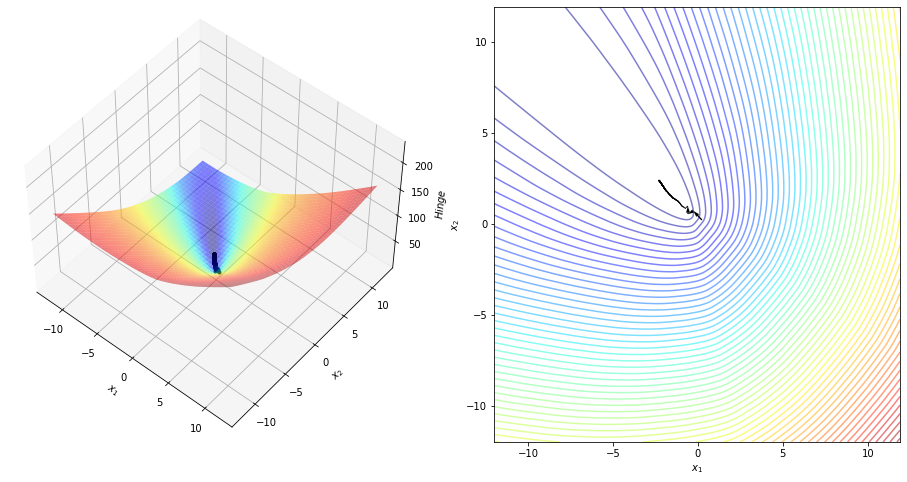

In [220]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate=0.5, 
                              max_iter=1000, early_stopping=True, patience=5),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_hinge_loss.png')

In [221]:
custom_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_hinge_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svc_hinge_cv_results.set_index(['solver', 'C'], inplace=True)
custom_primal_svc_hinge_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver  C                                                                 
adagrad 1    0.045228        0.967475      0.969848      66          20   
        10   0.247653        0.972468      0.974898     398          12   
        100  0.301816        0.972468      0.974898     593          10   

             val_n_sv  
solver  C              
adagrad 1          10  
        10          7  
        100         7

In [222]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [223]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'C'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver    C                                                                 
liblinear 1    0.001328        0.982494      0.980024     153          12   
          10   0.001203        0.987487      0.989974     633           7   
          100  0.001864        0.985000      0.984999     831           7   

               val_n_sv  
solver    C              
liblinear 1           5  
          10          4  
          100         3

In [224]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', 
                                     caption='SVC Primal formulation results with Hinge loss', 
                                     label='primal_svc_hinge_cv_results', position='h!')
primal_svc_hinge_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver    C                                                                 
adagrad   1    0.045228        0.967475      0.969848      66          20   
          10   0.247653        0.972468      0.974898     398          12   
          100  0.301816        0.972468      0.974898     593          10   
liblinear 1    0.001328        0.982494      0.980024     153          12   
          10   0.001203        0.987487      0.989974     633           7   
          100  0.001864        0.985000      0.984999     831           7   

               val_n_sv  
solver    C              
adagrad   1          10  
          10          7  
          100         7  
liblinear 1           5  
          10          4  
          100         3

### Dual formulations

In [225]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [249]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [250]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (0 if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter), 
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


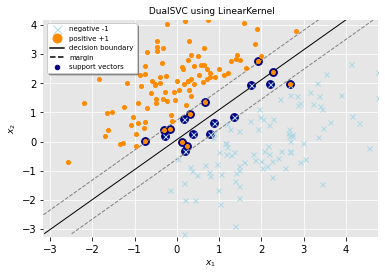

In [259]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [260]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results['n_iter'].replace(0, '-', inplace=True)
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver C                                                                 
cvxopt 1    0.015791        0.972487      0.959897       1          15   
       10   0.025156        0.972487      0.959897       1          11   
       100  0.028108        0.972487      0.959897       1          38   
smo    1    0.042172        0.972487      0.959897      23          15   
       10   0.114690        0.972487      0.959897      76          11   
       100  0.281406        0.972487      0.959897     411          10   

            val_n_sv  
solver C              
cvxopt 1          15  
       10         11  
       100        38  
smo    1          15  
       10         11  
       100        10

In [261]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM]

In [262]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver C                                                                 
libsvm 1    0.002600        0.987506      0.985075     209          12   
       10   0.004442        0.990012      0.980100     213           8   
       100  0.002549        0.990012      0.980100     757           7   

            val_n_sv  
solver C              
libsvm 1          12  
       10          8  
       100         7

In [263]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', 
                                    caption='Linear SVC Wolfe Dual formulation results with Hinge loss', 
                                    label='linear_dual_svc_cv_results', position='h!')
linear_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver C                                                                 
cvxopt 1    0.015791        0.972487      0.959897       1          15   
       10   0.025156        0.972487      0.959897       1          11   
       100  0.028108        0.972487      0.959897       1          38   
smo    1    0.042172        0.972487      0.959897      23          15   
       10   0.114690        0.972487      0.959897      76          11   
       100  0.281406        0.972487      0.959897     411          10   
libsvm 1    0.002600        0.987506      0.985075     209          12   
       10   0.004442        0.990012      0.980100     213           8   
       100  0.002549        0.990012      0.980100     757           7   

            val_n_sv  
solver C              
cvxopt 1          15  
       10         11  
       100        38  
smo    1          15  
       10         11  
       100        10  
libsvm 1          12  
       10          8  
       100         7

##### Nonlinear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


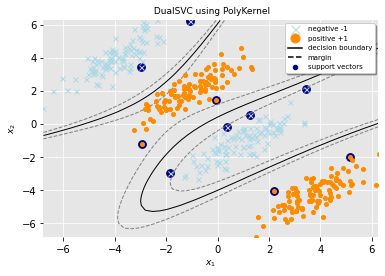

In [269]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [270]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results['n_iter'].replace(0, '-', inplace=True)
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.128965        0.852492      0.728519       1          30   
              10   0.117962        0.923686      0.760857       1          10   
              100  0.090554        0.956197      0.835615       1           8   
smo    poly   1    0.452768        0.851243      0.730988     114          29   
              10   0.383016        0.922437      0.763364      71          10   
              100  0.343767        0.947429      0.803296     132           9   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          30  
              10         10  
              100         8  
smo    poly   1          29  
              10         10  
              100         9

Fitting 3 folds for each of 6 candidates, totalling 18 fits


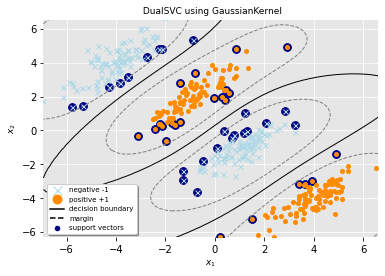

In [271]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [272]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results['n_iter'].replace(0, '-', inplace=True)
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver kernel C                                                                 
cvxopt rbf    1    0.132866             1.0      0.997494       1          43   
              10   0.123202             1.0      0.997494       1          15   
              100  0.094838             1.0      0.994987       1          12   
smo    rbf    1    0.287587             1.0      0.997494      41          42   
              10   0.259508             1.0      0.994987      43          13   
              100  0.319339             1.0      0.994987     101          12   

                   val_n_sv  
solver kernel C              
cvxopt rbf    1          43  
              10         15  
              100        12  
smo    rbf    1          42  
              10         13  
              100        12

In [273]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.128965        0.852492      0.728519       1          30   
              10   0.117962        0.923686      0.760857       1          10   
              100  0.090554        0.956197      0.835615       1           8   
       rbf    1    0.132866        1.000000      0.997494       1          43   
              10   0.123202        1.000000      0.997494       1          15   
              100  0.094838        1.000000      0.994987       1          12   
smo    poly   1    0.452768        0.851243      0.730988     114          29   
              10   0.383016        0.922437      0.763364      71          10   
              100  0.343767        0.947429      0.803296     132           9   
       rbf    1    0.287587        1.000000      0.997494      41          42   
              10   0.259508        1.000000      0.994987      43          13   
              100  0.319339        1.000000      0.994987     101          12   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          30  
              10         10  
              100         8  
       rbf    1          43  
              10         15  
              100        12  
smo    poly   1          29  
              10         10  
              100         9  
       rbf    1          42  
              10         13  
              100        12

In [274]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LibSVM]

In [275]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver kernel C                                                                 
libsvm poly   1    0.009136             1.0      0.992481     287          30   
              10   0.005259             1.0      0.984962     504          12   
              100  0.003439             1.0      0.974937     460           8   
       rbf    1    0.005949             1.0      0.997512     121          46   
              10   0.003889             1.0      1.000000     214          15   
              100  0.002700             1.0      1.000000     105          11   

                   val_n_sv  
solver kernel C              
libsvm poly   1          30  
              10         12  
              100         8  
       rbf    1          46  
              10         15  
              100        11

In [276]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', 
                                       caption='Nonlinear SVC Wolfe Dual formulation results with Hinge loss', 
                                       label='nonlinear_dual_svc_cv_results', position='h!')
nonlinear_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
solver kernel C                                                                 
cvxopt poly   1    0.128965        0.852492      0.728519       1          30   
              10   0.117962        0.923686      0.760857       1          10   
              100  0.090554        0.956197      0.835615       1           8   
       rbf    1    0.132866        1.000000      0.997494       1          43   
              10   0.123202        1.000000      0.997494       1          15   
              100  0.094838        1.000000      0.994987       1          12   
libsvm poly   1    0.009136        1.000000      0.992481     287          30   
              10   0.005259        1.000000      0.984962     504          12   
              100  0.003439        1.000000      0.974937     460           8   
       rbf    1    0.005949        1.000000      0.997512     121          46   
              10   0.003889        1.000000      1.000000     214          15   
              100  0.002700        1.000000      1.000000     105          11   
smo    poly   1    0.452768        0.851243      0.730988     114          29   
              10   0.383016        0.922437      0.763364      71          10   
              100  0.343767        0.947429      0.803296     132           9   
       rbf    1    0.287587        1.000000      0.997494      41          42   
              10   0.259508        1.000000      0.994987      43          13   
              100  0.319339        1.000000      0.994987     101          12   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          30  
              10         10  
              100         8  
       rbf    1          43  
              10         15  
              100        12  
libsvm poly   1          30  
              10         12  
              100         8  
       rbf    1          46  
              10         15  
              100        11  
smo    poly   1          29  
              10         10  
              100         9  
       rbf    1          42  
              10         13  
              100        12

#### Lagrangian Dual

##### Linear

In [313]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [314]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', 
                                               caption='Linear SVC Lagrangian Dual formulation results with Hinge loss', 
                                               label='linear_lagrangian_dual_svc_cv_results', position='h!')
linear_lagrangian_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  val_n_sv
dual C                                                                        
bcqp 1    0.006401        0.992519       0.99005       1         130       130
     10   0.006864        0.992519       0.99005       1         130       130
     100  0.005661        0.992519       0.99005       1         130       130
qp   1    0.005798        0.995006       0.99005       1         132       132
     10   0.006755        0.995006       0.99005       1         132       132
     100  0.006650        0.995006       0.99005       1         132       132

##### Nonlinear

In [315]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [316]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', 
                                                  caption='Nonlinear SVC Lagrangian Dual formulation results with Hinge loss', 
                                                  label='nonlinear_lagrangian_dual_svc_cv_results', position='h!')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  train_n_sv  \
dual kernel C                                                                 
bcqp poly   1    0.070312        0.806196      0.553791       4         211   
            10   0.051106        0.806196      0.553791       4         211   
            100  0.033508        0.806196      0.553791       4         211   
     rbf    1    0.057051        1.000000      0.994987       1         246   
            10   0.024727        1.000000      0.994987       1         246   
            100  0.023880        1.000000      0.994987       1         246   
qp   poly   1    0.601361        0.804934      0.551378     102         178   
            10   0.598967        0.804934      0.551378     102         178   
            100  0.455699        0.804934      0.551378     102         178   
     rbf    1    1.002897        0.776332      0.600363     126         151   
            10   0.731749        0.891207      0.745670     155         197   
            100  0.297122        0.860001      0.728089      49         160   

                 val_n_sv  
dual kernel C              
bcqp poly   1         211  
            10        211  
            100       211  
     rbf    1         246  
            10        246  
            100       246  
qp   poly   1         178  
            10        178  
            100       178  
     rbf    1         151  
            10        197  
            100       160

## Squared Hinge loss

### Primal formulation

In [287]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [288]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


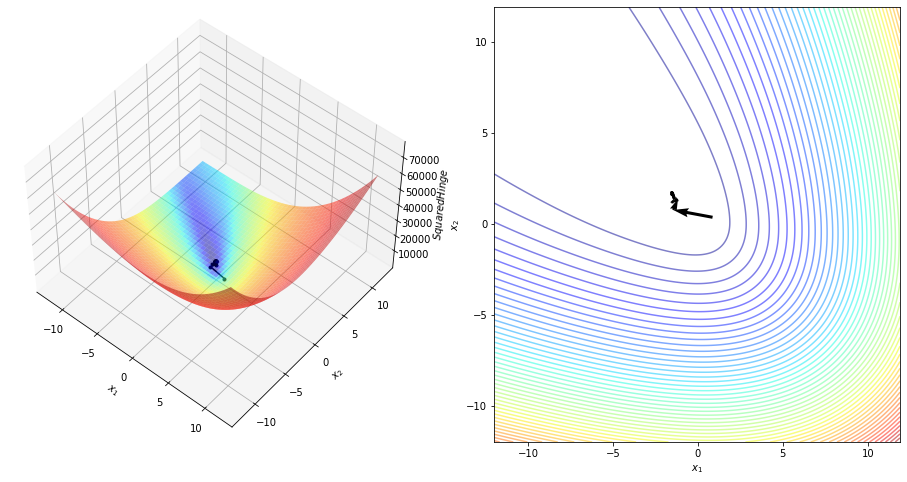

In [289]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, 
                              learning_rate=0.01, momentum=0.5, early_stopping=True, patience=5),
                    param_grid={'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_squared_hinge_loss.png')

In [290]:
custom_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'gd')
custom_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
custom_primal_svc_squared_hinge_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  \
solver C   momentum                                                   
gd     1   none      0.123503        0.984962      0.969923     123   
           standard  0.071623        0.984962      0.974898      81   
           nesterov  0.128726        0.979987      0.974898     101   
       10  none      0.086649        0.977462      0.974898     125   
           standard  0.061827        0.984962      0.974898     124   
           nesterov  0.026249        0.984962      0.969923      37   
       100 none      0.034297        0.979969      0.984848      45   
           standard  0.014864        0.982475      0.974898      20   
           nesterov  0.012460        0.982475      0.974898      18   

                     train_n_sv  val_n_sv  
solver C   momentum                        
gd     1   none              30        18  
           standard          26        13  
           nesterov          24        13  
       10  none              16         9  
           standard          14         8  
           nesterov          15         8  
       100 none               8         3  
           standard           6         3  
           nesterov           5         2

In [291]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='squared_hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [292]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  \
solver    C   momentum                                                   
liblinear 1   -         0.001369        0.965025      0.960124     290   
          10  -         0.002461        0.965025      0.955148    1001   
          100 -         0.002265        0.970018      0.945198    1001   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
liblinear 1   -                 23        11  
          10  -                 22        11  
          100 -                 22        11

In [293]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', 
                                             caption='SVC Primal formulation results with Squared Hinge loss', 
                                             label='primal_svc_squared_hinge_cv_results', position='h!')
primal_svc_squared_hinge_cv_results

fit_time  train_accuracy  val_accuracy  n_iter  \
solver    C   momentum                                                   
gd        1   none      0.123503        0.984962      0.969923     123   
              standard  0.071623        0.984962      0.974898      81   
              nesterov  0.128726        0.979987      0.974898     101   
          10  none      0.086649        0.977462      0.974898     125   
              standard  0.061827        0.984962      0.974898     124   
              nesterov  0.026249        0.984962      0.969923      37   
          100 none      0.034297        0.979969      0.984848      45   
              standard  0.014864        0.982475      0.974898      20   
              nesterov  0.012460        0.982475      0.974898      18   
liblinear 1   -         0.001369        0.965025      0.960124     290   
          10  -         0.002461        0.965025      0.955148    1001   
          100 -         0.002265        0.970018      0.945198    1001   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
gd        1   none              30        18  
              standard          26        13  
              nesterov          24        13  
          10  none              16         9  
              standard          14         8  
              nesterov          15         8  
          100 none               8         3  
              standard           6         3  
              nesterov           5         2  
liblinear 1   -                 23        11  
          10  -                 22        11  
          100 -                 22        11